# Training the controller using CMA-ES + RNN hidden state

In [ ]:
import numpy as np
import pandas as pd
import cma
import time
import math
import tensorflow as tf

from scipy.special import softmax
import matplotlib.pyplot as plt

# Import openai Gym 
import gym
import atari_py

In [2]:
!python -m atari_py.import_roms /work/ROMS

In [3]:
env = gym.make('MsPacman-ram-v0')

In [5]:
# Controller definition (this controls the PacMan environment)
class Controller():
    
    def __init__(self, input_neurons, output_neurons):
        # Randomly initialise weigths and set bias to zero        
        np.random.seed(42)
        self.weights = np.random.rand(input_neurons, output_neurons)
        self.bias = np.zeros(output_neurons)
        
    def predict(self, x):
        dot = np.dot(x, self.weights) + self.bias
        return softmax(dot)
    
    def update_params(self, weights, bias):
        self.weights = weights
        self.bias = bias

In [6]:
def predict_controller(controller, ram):
    ram = np.expand_dims(ram, axis=0)
    
     # Predict the next action given the current state
    action = np.argmax(controller.predict(ram), axis=-1)[0]
    
    return action

In [7]:
# Extract weights and biases from controller
def get_controller_parameters(controller):
    weights = controller.weights
    biases  = controller.bias
    
    return weights, biases

# Flatten and concatenate parameters such that we can feed them to the ES algorithm
def flatten_parameters(weights, biases):
    weights_flattened = weights.flatten()
    
    return np.concatenate([weights_flattened, biases])

# Restore parameters such that we can put them back into the controller
def restore_parameters(parameters, weight_length, bias_length):
    weights = parameters[0:-bias_length]
    weights = weights.reshape([weight_length, bias_length])
    
    biases = parameters[-bias_length:]
    
    return weights, biases

## CMA-ES

In [8]:
def compute_cost(reward):
    
    # 6000 is more than the top score on the openai leaderboard 
    # https://github.com/openai/gym/wiki/Leaderboard#mspacman-v0
    return 6000 - reward
    
def run_pacman(controller, runs, action_space=None):
    
    total_reward = 0
    total_cost = 0
    action_collector = []
    reward_collector = []
    
    # Run PacMan for the specified number of runs
    for i in range(runs):
        
        done = False
        
        # hidden = np.zeros(256)
        # cell_values = np.zeros(256)
        collect_reward = 0
        
        state = env.reset()
        while not done:
            # Predict next action using the controller
            action = predict_controller(controller, state)
            
            # Set a step for the predicted action
            state, reward, done, info = env.step(action) 
            
            collect_reward += reward
            reward_collector.append(reward)
            action_collector.append(action)
            
#             time.sleep(0.1) uncomment for visualising PacMan
#             env.render()
        
        total_reward += collect_reward
        total_cost += compute_cost(collect_reward)
    env.close()
    
    avg_action = sum(action_collector)/len(action_collector)
    avg_reward = total_reward/runs
    print(np.std(reward_collector))
    avg_cost = total_cost/runs
        
    return avg_reward, avg_cost, avg_action, action_collector
    

# Method for evaluating the controller
def evaluate_controller(controller, solution, runs, action_space):
    weights, bias = restore_parameters(solution, 128, 9)
    
    # Update controller parameters and run pacman
    controller.update_params(weights, bias)
    reward, cost, avg_action, distribution = run_pacman(controller, runs, action_space)
    
    return reward, cost, avg_action, distribution

In [ ]:
# Extract model parameters
input_dimension = 128 # rnn hidden state + ram state
controller = Controller(input_dimension, 9)
weights, biases = get_controller_parameters(controller)

# Flatten and concatenate parameters to desired ES input shape
flat_params = flatten_parameters(weights, biases)

# Define population size and initialize CMA-ES
# Look at hyperparameters (maybe)
pop_size = 20
std = 0.5
epochs = 500
es = cma.CMAEvolutionStrategy(flat_params, std,
                              {'popsize': pop_size})

# Define variables for keeping track of the system behaviour
generation = 0
best_rewards = []
generation_of_change = []

generation_distance = []
best_generation = 0
action_collector = []
reward_collector = []
best_generation_action = []
elapse_time_col = []
best_reward = 0
best_solution = []

# Define action space (use [1, 2, 3, 4] for an action space of 4)
action_space = list(range(9))

total_time = time.time()

# Run the CMA-ES algorithm until convergence or the max number of epochs is reached
while not es.stop() and generation < epochs:

    print('############ GENERATION ', generation +1, '############')

    # Fetch new solutions for this generation
    solutions = es.ask()
    rewards = []
    costs = []
    avg_action_collect = []
    total_action_collect = []
    
    # Evaluate the different solutions
    t = time.time()

    for index, solution in enumerate(solutions):
        avg_reward, avg_cost, avg_action, actions = evaluate_controller(controller, solution, 3, action_space)
        
        # Store results
        rewards.append(avg_reward)
        costs.append(avg_cost)
        avg_action_collect.append(avg_action)
        total_action_collect.append(actions)
    
    # Store generation outcomes
    elapsed = time.time() - t
    elapse_time_col.append(elapsed)
    print(f"Average elapsed time per population: {elapsed / pop_size}")
    
    action_collector.append(sum(avg_action_collect) / pop_size)
    reward_collector.append(sum(rewards) / pop_size)
    print(f"Average reward: {sum(rewards) / pop_size}")
    
    max_reward = max(rewards)
    if max_reward > best_reward:
        print(f"Obtained a new high score: {max_reward}")
        
        # Store reward of new best solution
        best_rewards.append(max_reward)
        generation_distance.append(generation - best_generation)
        generation_of_change.append(generation)
        
        # Store action sequence of new best solution
        best_reward_index = np.argmax(rewards)
        best_generation_action.append(total_action_collect[best_reward_index])
        
        # Store new best solution
        best_solution = solutions[best_reward_index]
        
        # Update best generation index
        best_generation = generation
        
        best_reward = max_reward
        
    generation += 1


    # Pass the solutions + corresponding rewards to the ES
    es.tell(solutions, costs)

# Print results
print(f"Stopped or converged after: {generation} generations. Elapsed time {time.time() - total_time} seconds\n")
print("========================================================================================================\n")
es.result_pretty()

In [10]:
controller.weights.shape

(128, 9)

In [ ]:
# # available actions 
# 0 = 'NOOP'
# 1 = 'UP'
# 2 = 'RIGHT'
# 3 = 'LEFT'
# 4 = 'DOWN'
# 5 = 'UPRIGHT'
# 6 = 'UPLEFT'
# 7 = 'DOWNRIGHT'
# 8 = 'DOWNLEFT'

In [10]:
# Define name for producing outputs
output_name = "9_random_20_0.5"

In [11]:
best_reward

3570.0

In [12]:
generation_of_change

[0, 1, 4, 9, 13, 16, 17, 30, 48, 88, 95, 118, 371, 435, 477, 499]

In [13]:
## Save the best solution
np.save(f"model_weights/{output_name}_weights.npy", best_solution)

## Visualising output

<ipython-input-14-ef52cafb5dcb>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 864x576 with 0 Axes>

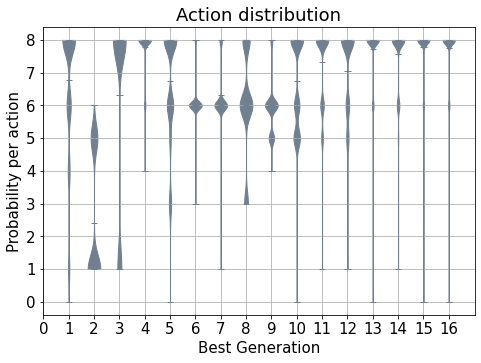

In [14]:
# unique, counts = np.unique(all_actions[0], return_counts=True)
# distribution = dict(zip(unique, counts))

plt.rcParams.update({'font.size': 15})

# Create a figure instance
fig = plt.figure(figsize=(12, 8))

data_to_plot = []
for i in range(len(best_generation_action)):
    data_to_plot.append(best_generation_action[i])

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot, showmeans = True, showextrema = True, showmedians = True)

for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = bp[partname]
    vp.set_edgecolor('slategray')
    vp.set_linewidth(1)

for pc in bp['bodies']:
    pc.set_facecolor('slategray')
    pc.set_edgecolor('slategray')
    pc.set_alpha(1)

plt.grid()
plt.xlabel('Best Generation') 
plt.ylabel('Probability per action')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, len(data_to_plot) +1, 1))
plt.title("Action distribution") 
plt.tight_layout()
plt.savefig(f'output_imgs/{output_name}_best_actions_distribution.png', bbox_inches='tight', format='png')
plt.show()

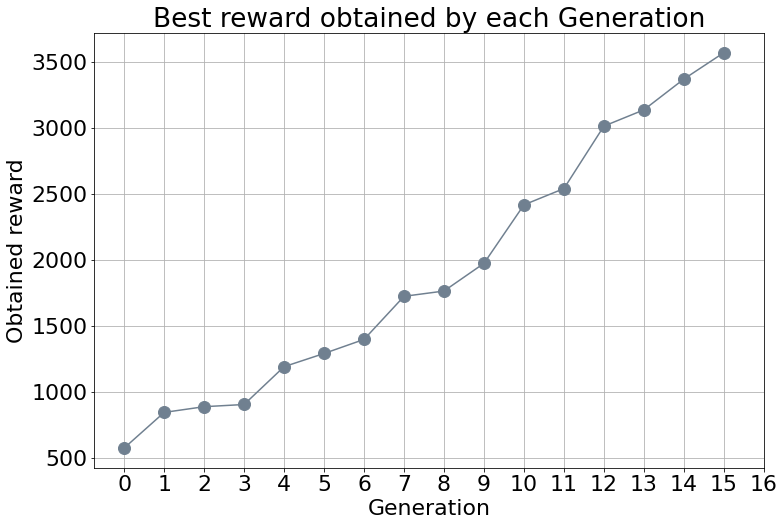

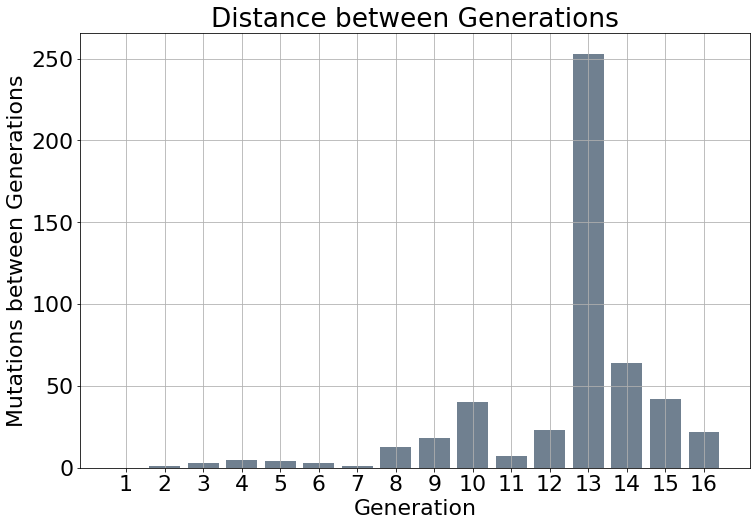

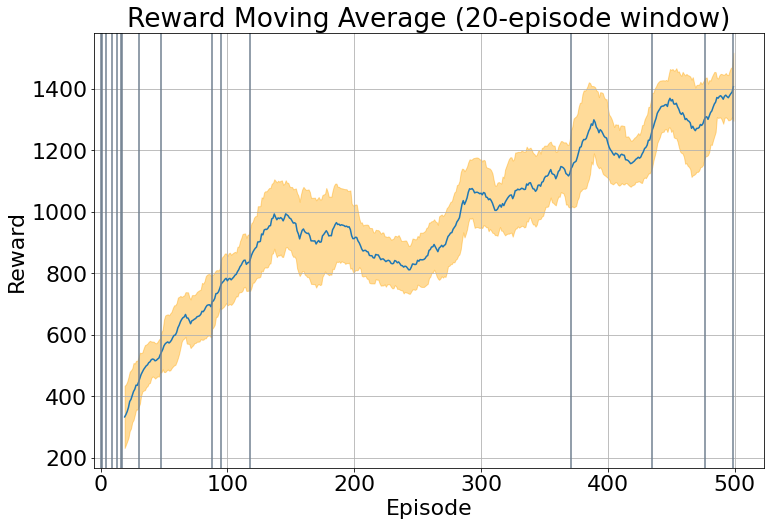

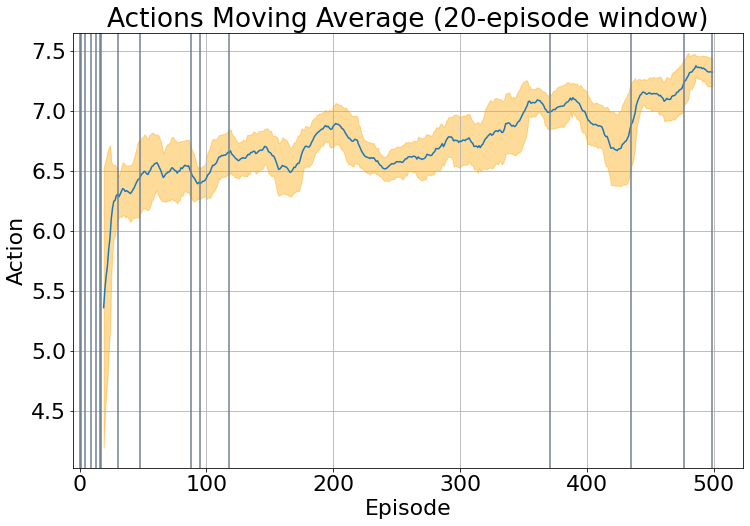

In [15]:
# plotting

# plot the obtained results
plt.rcParams.update({'font.size': 22})

# Reward improvement per generation
plt.figure(figsize=(12, 8))
plt.plot(best_rewards, color='slategray', marker = 'o', markersize=12)
#plt.style.use('ggplot')
plt.grid()
plt.xticks(range(0, len(generation_distance)+1, 1))
plt.xlabel('Generation') 
plt.ylabel('Obtained reward') 
plt.title("Best reward obtained by each Generation")
plt.savefig(f'output_imgs/{output_name}_best_reward_per_gen.png', bbox_inches='tight', format='png')
# plt.savefig('img-GA/pacman-reward-1000-sigma0.8-sparse-action8-evaldepth5.pdf')
plt.show() 

# Distance between generations
plt.figure(figsize=(12, 8))
plt.bar(range(1, len(generation_distance)+1, 1), generation_distance, color='slategray')
#plt.style.use('ggplot')
plt.grid()
plt.xticks(range(1, len(generation_distance)+1, 1))
plt.xlabel('Generation')
plt.ylabel('Mutations between Generations')
plt.title("Distance between Generations")
plt.savefig(f'output_imgs/{output_name}_best_gen_distance.png', bbox_inches='tight', format='png')
# plt.savefig('img-GA/pacman-distance-1000-simga0.8-sparse-action8-evaldepth5.pdf')
plt.show() 


# Plot all rewards

# change red and gray colour?
window=20
xcoords = generation_of_change

plt.figure(figsize=(12,8))
rolling_mean = pd.Series(reward_collector).rolling(window).mean()
std = pd.Series(reward_collector).rolling(window).std()
plt.grid()
plt.plot(rolling_mean)
plt.fill_between(range(len(reward_collector)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.4)
# plt.axvline(x=30, color='slategray', linestyle='-')

for xc in zip(xcoords):
    plt.axvline(x=xc, label='line at x = {}'.format(xc), c='slategray')

plt.title('Reward Moving Average ({}-episode window)'.format(window))
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.savefig(f'output_imgs/{output_name}_reward_moving_avg.png', bbox_inches='tight', format='png')
# plt.savefig('img-GA/pacman-reward-over-1000-sigma0.8-sparse-action8-evaldepth5.pdf')
plt.show()

# Plot all action

plt.figure(figsize=(12,8))
rolling_mean = pd.Series(action_collector).rolling(window).mean()
std = pd.Series(action_collector).rolling(window).std()
plt.plot(rolling_mean)
plt.fill_between(range(len(action_collector)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.4)

for xc in zip(xcoords):
    plt.axvline(x=xc, label='line at x = {}'.format(xc), c='slategray')

plt.title('Actions Moving Average ({}-episode window)'.format(window))
plt.grid()
plt.savefig(f'output_imgs/{output_name}_actions_moving_avg.png', bbox_inches='tight', format='png')
# plt.savefig('img-GA/pacman-actions-over-1000-sigma0.8-sparse-action8-evaldepth5.pdf', bbox_inches='tight')
plt.xlabel('Episode')
plt.ylabel('Action')
plt.show()

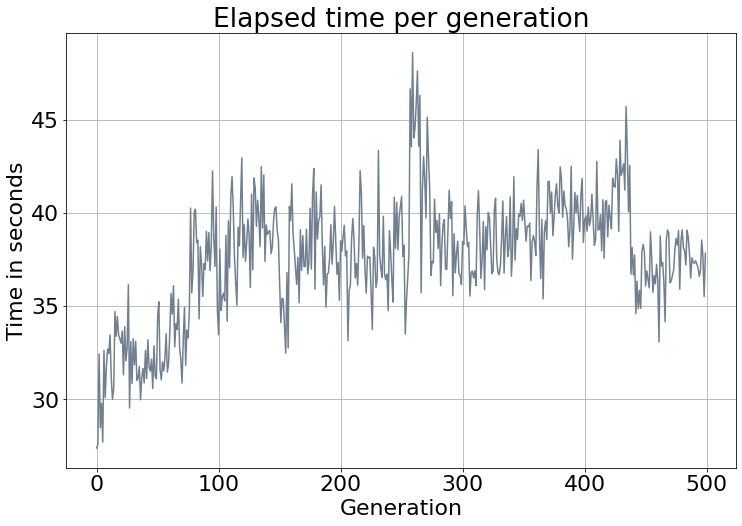

In [16]:
total = sum(elapse_time_col)

plt.figure(figsize=(12, 8))
plt.plot(elapse_time_col, color='slategray')
plt.xlabel('Generation') 
plt.ylabel('Time in seconds')

plt.title("Elapsed time per generation" ) 
plt.grid()
plt.savefig(f'output_imgs/{output_name}_elapsed_time.png', bbox_inches='tight', format='png')
# plt.savefig('img-GA/pacman-elapse-time-1000-sigma0.8-sparse-action8-evaldepth5.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(np.min(all_rewards, axis=1), label="minimal reward")
# plt.plot(np.mean(all_rewards, axis=1), label="average reward")
# plt.plot(np.max(all_rewards, axis=1), label="max reward")
# plt.legend()
# plt.show()

## Evaluation
Evaluate performance over 10 fresh runs

In [ ]:
test_controller = Controller(128, 9)
test_sol = np.load('model_weights/9_random_20_0.01_weights.npy')
test_w, test_b = restore_parameters(test_sol, 128, 9)

reward, _, _, _ = evaluate_controller(test_controller, test_sol, 10, None)
print(f"Average reward: {reward}")